# License Plate Detection Training with YOLOv8

This notebook trains a custom YOLOv8 model using your license plate dataset.
Dataset location: `/home/ikoafian/COMPANY/ieko-media/dataset/`

## 1. Setup and Dependencies

In [1]:
# Install required packages
!pip install ultralytics roboflow opencv-python pillow matplotlib seaborn pandas numpy
!pip install xmltodict pyyaml tqdm scikit-learn


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import xml.etree.ElementTree as ET
import yaml
import shutil
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

print("✅ All imports successful!")

✅ All imports successful!


## 2. Dataset Analysis

In [4]:
# Dataset paths
DATASET_ROOT = Path("/home/ikoafian/COMPANY/ieko-media/dataset")
IMAGES_DIR = DATASET_ROOT / "images"
ANNOTATIONS_DIR = DATASET_ROOT / "annotations"

# Output paths for YOLO format
YOLO_DATASET_ROOT = Path("/home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/dataset_yolo")
TRAIN_IMAGES_DIR = YOLO_DATASET_ROOT / "train" / "images"
TRAIN_LABELS_DIR = YOLO_DATASET_ROOT / "train" / "labels"
VAL_IMAGES_DIR = YOLO_DATASET_ROOT / "val" / "images"
VAL_LABELS_DIR = YOLO_DATASET_ROOT / "val" / "labels"
TEST_IMAGES_DIR = YOLO_DATASET_ROOT / "test" / "images"
TEST_LABELS_DIR = YOLO_DATASET_ROOT / "test" / "labels"

# Create directories
for dir_path in [TRAIN_IMAGES_DIR, TRAIN_LABELS_DIR, VAL_IMAGES_DIR, VAL_LABELS_DIR, TEST_IMAGES_DIR, TEST_LABELS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

print(f"Dataset root: {DATASET_ROOT}")
print(f"Images: {len(list(IMAGES_DIR.glob('*.png')))} files")
print(f"Annotations: {len(list(ANNOTATIONS_DIR.glob('*.xml')))} files")

Dataset root: /home/ikoafian/COMPANY/ieko-media/dataset
Images: 433 files
Annotations: 433 files


In [5]:
# Analyze dataset statistics
image_files = list(IMAGES_DIR.glob('*.png'))
annotation_files = list(ANNOTATIONS_DIR.glob('*.xml'))

print(f"Total images: {len(image_files)}")
print(f"Total annotations: {len(annotation_files)}")

# Check for matching image-annotation pairs
image_names = {f.stem for f in image_files}
annotation_names = {f.stem for f in annotation_files}

matched_names = image_names.intersection(annotation_names)
print(f"Matched pairs: {len(matched_names)}")
print(f"Images without annotations: {len(image_names - annotation_names)}")
print(f"Annotations without images: {len(annotation_names - image_names)}")

# Sample some filenames
print("\nSample files:")
for name in list(matched_names)[:5]:
    print(f"  {name}.png / {name}.xml")

Total images: 433
Total annotations: 433
Matched pairs: 433
Images without annotations: 0
Annotations without images: 0

Sample files:
  Cars341.png / Cars341.xml
  Cars387.png / Cars387.xml
  Cars360.png / Cars360.xml
  Cars326.png / Cars326.xml
  Cars74.png / Cars74.xml


## 3. XML to YOLO Conversion Functions

In [6]:
def parse_xml_annotation(xml_path):
    """Parse Pascal VOC XML annotation file"""
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        # Get image dimensions
        size = root.find('size')
        if size is not None:
            width = int(size.find('width').text)
            height = int(size.find('height').text)
        else:
            return None, None, None  # Skip if no size info
        
        # Get all objects (license plates)
        objects = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            bbox = obj.find('bndbox')
            
            if bbox is not None:
                xmin = int(float(bbox.find('xmin').text))
                ymin = int(float(bbox.find('ymin').text))
                xmax = int(float(bbox.find('xmax').text))
                ymax = int(float(bbox.find('ymax').text))
                
                objects.append({
                    'name': name,
                    'bbox': [xmin, ymin, xmax, ymax]
                })
        
        return width, height, objects
        
    except Exception as e:
        print(f"Error parsing {xml_path}: {e}")
        return None, None, None

def bbox_to_yolo_format(bbox, img_width, img_height):
    """Convert Pascal VOC bbox to YOLO format"""
    xmin, ymin, xmax, ymax = bbox
    
    # Calculate center coordinates and dimensions
    x_center = (xmin + xmax) / 2.0
    y_center = (ymin + ymax) / 2.0
    width = xmax - xmin
    height = ymax - ymin
    
    # Normalize by image dimensions
    x_center /= img_width
    y_center /= img_height
    width /= img_width
    height /= img_height
    
    return x_center, y_center, width, height

# Test the functions
sample_xml = list(ANNOTATIONS_DIR.glob('*.xml'))[0]
width, height, objects = parse_xml_annotation(sample_xml)
print(f"Sample annotation - {sample_xml.name}:")
print(f"  Image size: {width}x{height}")
print(f"  Objects: {len(objects) if objects else 0}")
if objects:
    for obj in objects[:2]:  # Show first 2 objects
        bbox = obj['bbox']
        yolo_bbox = bbox_to_yolo_format(bbox, width, height)
        print(f"    {obj['name']}: {bbox} -> {yolo_bbox}")

Sample annotation - Cars419.xml:
  Image size: 400x353
  Objects: 1
    licence: [195, 196, 349, 242] -> (0.68, 0.6203966005665722, 0.385, 0.13031161473087818)


## 4. Dataset Conversion and Splitting

In [7]:
# Get all valid image-annotation pairs
valid_pairs = []
skipped_count = 0

for name in tqdm(matched_names, desc="Processing annotations"):
    xml_path = ANNOTATIONS_DIR / f"{name}.xml"
    img_path = IMAGES_DIR / f"{name}.png"
    
    # Parse annotation
    width, height, objects = parse_xml_annotation(xml_path)
    
    if width and height and objects:
        # Verify image exists and dimensions match
        if img_path.exists():
            try:
                with Image.open(img_path) as img:
                    img_width, img_height = img.size
                    if img_width == width and img_height == height:
                        valid_pairs.append({
                            'name': name,
                            'img_path': img_path,
                            'xml_path': xml_path,
                            'width': width,
                            'height': height,
                            'objects': objects
                        })
                    else:
                        print(f"Dimension mismatch for {name}: XML({width},{height}) vs IMG({img_width},{img_height})")
                        skipped_count += 1
            except Exception as e:
                print(f"Error reading image {img_path}: {e}")
                skipped_count += 1
        else:
            skipped_count += 1
    else:
        skipped_count += 1

print(f"\nValid pairs: {len(valid_pairs)}")
print(f"Skipped: {skipped_count}")

Processing annotations: 100%|██████████| 433/433 [00:00<00:00, 1214.86it/s]


Valid pairs: 433
Skipped: 0


In [8]:
# Analyze object classes
class_counts = {}
total_objects = 0

for pair in valid_pairs:
    for obj in pair['objects']:
        class_name = obj['name']
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
        total_objects += 1

print(f"Class distribution ({total_objects} total objects):")
for class_name, count in sorted(class_counts.items()):
    print(f"  {class_name}: {count} ({count/total_objects*100:.1f}%)")

# Create class mapping (license plate -> class 0)
class_names = sorted(class_counts.keys())
class_to_id = {name: i for i, name in enumerate(class_names)}
print(f"\nClass mapping: {class_to_id}")

Class distribution (471 total objects):
  licence: 471 (100.0%)

Class mapping: {'licence': 0}


In [9]:
# Split dataset: 70% train, 20% val, 10% test
train_pairs, temp_pairs = train_test_split(valid_pairs, test_size=0.3, random_state=42)
val_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.33, random_state=42)  # 0.33 of 0.3 = ~0.1

print(f"Dataset split:")
print(f"  Train: {len(train_pairs)} ({len(train_pairs)/len(valid_pairs)*100:.1f}%)")
print(f"  Val: {len(val_pairs)} ({len(val_pairs)/len(valid_pairs)*100:.1f}%)")
print(f"  Test: {len(test_pairs)} ({len(test_pairs)/len(valid_pairs)*100:.1f}%)")

Dataset split:
  Train: 303 (70.0%)
  Val: 87 (20.1%)
  Test: 43 (9.9%)


In [10]:
def convert_and_copy_data(pairs, images_dir, labels_dir, split_name):
    """Convert annotations to YOLO format and copy files"""
    
    converted_count = 0
    error_count = 0
    
    for pair in tqdm(pairs, desc=f"Converting {split_name}"):
        try:
            # Copy image
            dest_img_path = images_dir / f"{pair['name']}.png"
            shutil.copy2(pair['img_path'], dest_img_path)
            
            # Convert annotation to YOLO format
            yolo_lines = []
            for obj in pair['objects']:
                class_id = class_to_id[obj['name']]
                x_center, y_center, width, height = bbox_to_yolo_format(
                    obj['bbox'], pair['width'], pair['height']
                )
                yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
            
            # Save YOLO annotation
            dest_label_path = labels_dir / f"{pair['name']}.txt"
            with open(dest_label_path, 'w') as f:
                f.write('\n'.join(yolo_lines))
            
            converted_count += 1
            
        except Exception as e:
            print(f"Error converting {pair['name']}: {e}")
            error_count += 1
    
    print(f"{split_name} - Converted: {converted_count}, Errors: {error_count}")
    return converted_count, error_count

# Convert all splits
train_converted, train_errors = convert_and_copy_data(train_pairs, TRAIN_IMAGES_DIR, TRAIN_LABELS_DIR, "train")
val_converted, val_errors = convert_and_copy_data(val_pairs, VAL_IMAGES_DIR, VAL_LABELS_DIR, "val")
test_converted, test_errors = convert_and_copy_data(test_pairs, TEST_IMAGES_DIR, TEST_LABELS_DIR, "test")

print(f"\nTotal converted: {train_converted + val_converted + test_converted}")
print(f"Total errors: {train_errors + val_errors + test_errors}")

Converting train: 100%|██████████| 303/303 [00:00<00:00, 353.45it/s]


train - Converted: 303, Errors: 0


Converting val: 100%|██████████| 87/87 [00:00<00:00, 395.78it/s]


val - Converted: 87, Errors: 0


Converting test: 100%|██████████| 43/43 [00:00<00:00, 340.68it/s]

test - Converted: 43, Errors: 0

Total converted: 433
Total errors: 0


## 5. Create YOLO Dataset Configuration

In [11]:
# Create dataset.yaml for YOLO training
dataset_config = {
    'path': str(YOLO_DATASET_ROOT),
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'nc': len(class_names),  # number of classes
    'names': class_names     # class names
}

dataset_yaml_path = YOLO_DATASET_ROOT / 'dataset.yaml'
with open(dataset_yaml_path, 'w') as f:
    yaml.dump(dataset_config, f, default_flow_style=False)

print(f"Dataset configuration saved to: {dataset_yaml_path}")
print("\nDataset config:")
for key, value in dataset_config.items():
    print(f"  {key}: {value}")

Dataset configuration saved to: /home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/dataset_yolo/dataset.yaml

Dataset config:
  path: /home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/dataset_yolo
  train: train/images
  val: val/images
  test: test/images
  nc: 1
  names: ['licence']


## 6. Dataset Visualization

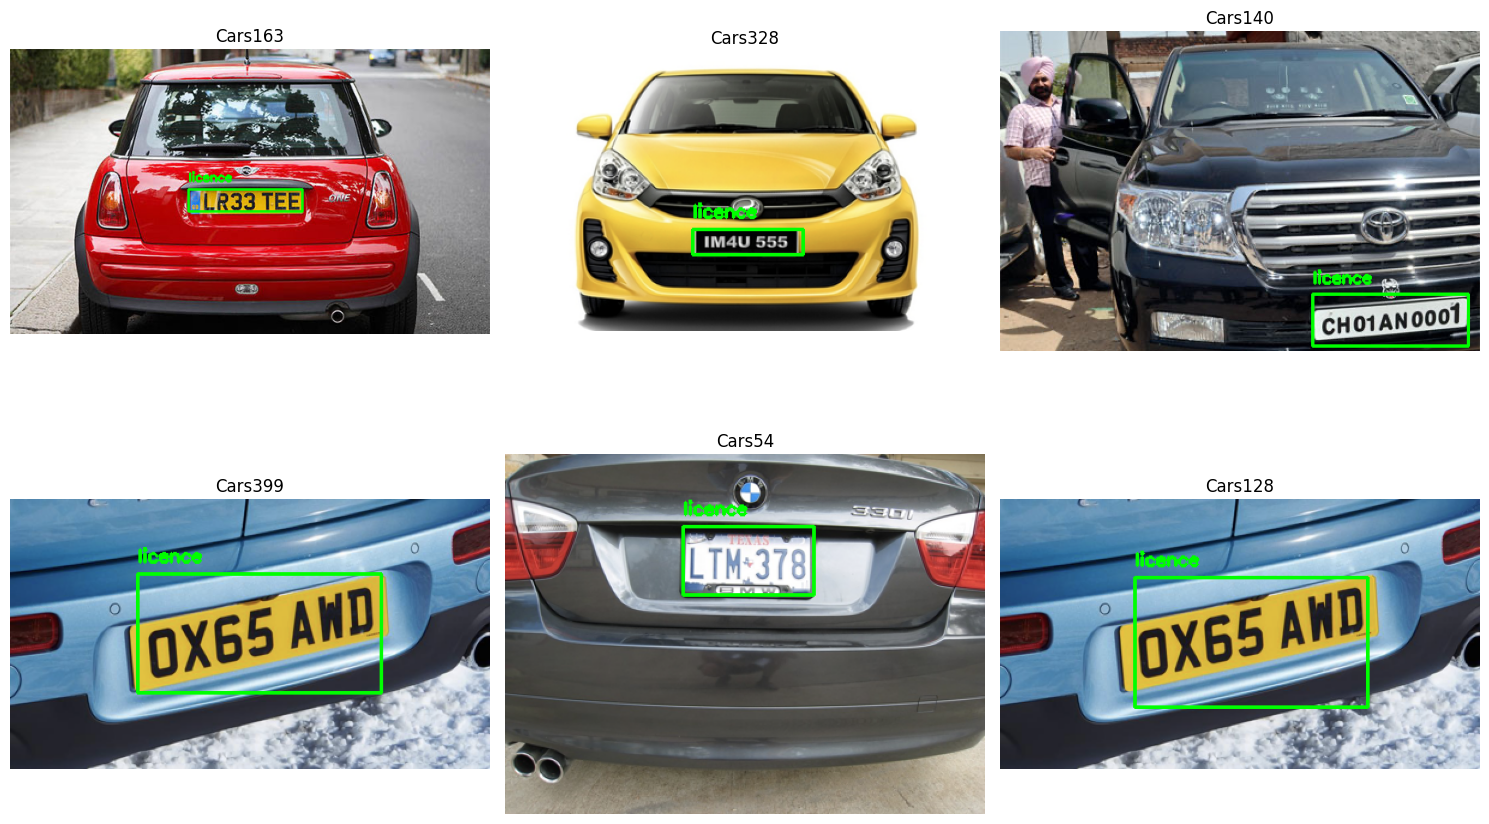

In [12]:
def visualize_yolo_annotation(img_path, label_path, class_names):
    """Visualize YOLO format annotation on image"""
    # Load image
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    # Load YOLO annotations
    if label_path.exists():
        with open(label_path, 'r') as f:
            lines = f.read().strip().split('\n')
        
        for line in lines:
            if line.strip():
                parts = line.split()
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:5])
                
                # Convert back to pixel coordinates
                x_center *= w
                y_center *= h
                width *= w
                height *= h
                
                # Calculate bbox corners
                x1 = int(x_center - width/2)
                y1 = int(y_center - height/2)
                x2 = int(x_center + width/2)
                y2 = int(y_center + height/2)
                
                # Draw bbox
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img, class_names[class_id], (x1, y1-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return img

# Visualize some training samples
sample_images = list(TRAIN_IMAGES_DIR.glob('*.png'))[:6]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, img_path in enumerate(sample_images):
    label_path = TRAIN_LABELS_DIR / f"{img_path.stem}.txt"
    
    img = visualize_yolo_annotation(img_path, label_path, class_names)
    axes[i].imshow(img)
    axes[i].set_title(f"{img_path.stem}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 7. YOLO Model Training

In [14]:
from ultralytics import YOLO

# Initialize YOLO model
model = YOLO('yolov8x.pt')  # Use nano model for faster training
# Alternative: 'yolov8s.pt' (small), 'yolov8m.pt' (medium), 'yolov8l.pt' (large), 'yolov8x.pt' (extra large)

print("✅ YOLO model loaded successfully!")

✅ YOLO model loaded successfully!


In [15]:
# Training parameters
EPOCHS = 100  # Adjust based on your needs and computational resources
IMAGE_SIZE = 640  # Standard YOLO input size
BATCH_SIZE = 16  # Adjust based on your GPU memory
WORKERS = 4  # Number of data loading workers

# Create models directory
models_dir = Path("/home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/models")
models_dir.mkdir(exist_ok=True)

print(f"Training configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Image size: {IMAGE_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Workers: {WORKERS}")
print(f"  Dataset: {dataset_yaml_path}")

Training configuration:
  Epochs: 100
  Image size: 640
  Batch size: 16
  Workers: 4
  Dataset: /home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/dataset_yolo/dataset.yaml


In [16]:
# Start training
results = model.train(
    data=str(dataset_yaml_path),
    epochs=EPOCHS,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    workers=WORKERS,
    device='cpu',  # Use 'cuda' if GPU is available
    project=str(models_dir),
    name='license_plate_detector',
    exist_ok=True,
    verbose=True,
    save=True,
    save_period=10,  # Save checkpoint every 10 epochs
    plots=True,
    val=True
)

print("\n✅ Training completed!")

New https://pypi.org/project/ultralytics/8.3.199 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.198 🚀 Python-3.12.6 torch-2.8.0+cu128 CPU (12th Gen Intel Core i5-12500H)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/dataset_yolo/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8x.pt, moment

/home/ikoafian/.pyenv/versions/3.12.6/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 469.4±127.6 MB/s, size: 527.5 KB)
val: Scanning /home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/dataset_yolo/val/labels... 87 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 87/87 396.0it/s 0.2s0.0s
val: New cache created: /home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/dataset_yolo/val/labels.cache
Plotting labels to /home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/models/license_plate_detector/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(deca

KeyboardInterrupt: 

## 8. Model Evaluation

In [17]:
# Load the best trained model
best_model_path = models_dir / "license_plate_detector" / "weights" / "best.pt"
if best_model_path.exists():
    trained_model = YOLO(str(best_model_path))
    print(f"✅ Loaded best model from: {best_model_path}")
else:
    print(f"❌ Best model not found at: {best_model_path}")
    # Use last model instead
    last_model_path = models_dir / "license_plate_detector" / "weights" / "last.pt"
    if last_model_path.exists():
        trained_model = YOLO(str(last_model_path))
        print(f"✅ Loaded last model from: {last_model_path}")
    else:
        print("❌ No trained model found!")
        trained_model = None

❌ Best model not found at: /home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/models/license_plate_detector/weights/best.pt
❌ No trained model found!


In [ ]:
if trained_model:
    # Evaluate on validation set
    val_results = trained_model.val(
        data=str(dataset_yaml_path),
        imgsz=IMAGE_SIZE,
        batch=BATCH_SIZE,
        device='cpu',
        verbose=True,
        plots=True
    )
    
    print("\n📊 Validation Results:")
    if hasattr(val_results, 'box'):
        print(f"  mAP@0.5: {val_results.box.map50:.4f}")
        print(f"  mAP@0.5:0.95: {val_results.box.map:.4f}")
        print(f"  Precision: {val_results.box.mp:.4f}")
        print(f"  Recall: {val_results.box.mr:.4f}")

## 9. Test Predictions

In [ ]:
if trained_model:
    # Test on some validation images
    test_images = list(VAL_IMAGES_DIR.glob('*.png'))[:6]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, img_path in enumerate(test_images):
        # Run prediction
        results = trained_model.predict(str(img_path), conf=0.3, verbose=False)
        
        # Load original image
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Draw predictions
        if results[0].boxes is not None:
            boxes = results[0].boxes
            for box in boxes:
                # Get box coordinates
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                conf = float(box.conf[0].cpu().numpy())
                cls = int(box.cls[0].cpu().numpy())
                
                # Draw bounding box
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(img, f'{class_names[cls]} {conf:.2f}', (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        axes[i].imshow(img)
        axes[i].set_title(f"{img_path.stem}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

## 10. Export Model

In [ ]:
if trained_model:
    # Export model for deployment
    export_path = models_dir / "license_plate_detector_final.pt"
    
    # Copy the best model to a final location
    shutil.copy2(best_model_path, export_path)
    
    print(f"✅ Model exported to: {export_path}")
    print(f"Model size: {export_path.stat().st_size / (1024*1024):.1f} MB")
    
    # Create model info file
    model_info = {
        'model_path': str(export_path),
        'dataset_path': str(dataset_yaml_path),
        'classes': class_names,
        'num_classes': len(class_names),
        'training_epochs': EPOCHS,
        'image_size': IMAGE_SIZE,
        'batch_size': BATCH_SIZE,
        'dataset_stats': {
            'train_images': len(train_pairs),
            'val_images': len(val_pairs),
            'test_images': len(test_pairs),
            'total_images': len(valid_pairs)
        }
    }
    
    model_info_path = models_dir / "license_plate_detector_info.yaml"
    with open(model_info_path, 'w') as f:
        yaml.dump(model_info, f, default_flow_style=False)
    
    print(f"✅ Model info saved to: {model_info_path}")

## 11. Usage Instructions

In [ ]:
if trained_model:
    print("🎉 Training Complete! Usage Instructions:")
    print("="*50)
    print()
    print(f"1. Trained model location: {export_path}")
    print(f"2. Model info: {model_info_path}")
    print(f"3. Dataset config: {dataset_yaml_path}")
    print()
    print("To use this model in your API:")
    print("1. Update your detector.py to load this model:")
    print(f'   model = YOLO("{export_path}")')
    print()
    print("2. Set environment variable:")
    print(f'   export YOLO_MODEL_PATH="{export_path}"')
    print()
    print("3. Test the model:")
    print(f'   from ultralytics import YOLO')
    print(f'   model = YOLO("{export_path}")')
    print(f'   results = model.predict("path/to/test/image.jpg")')
    print()
    print(f"Dataset summary:")
    print(f"  - Total images: {len(valid_pairs)}")
    print(f"  - Classes: {class_names}")
    print(f"  - Training set: {len(train_pairs)} images")
    print(f"  - Validation set: {len(val_pairs)} images")
    print(f"  - Test set: {len(test_pairs)} images")

## 12. Optional: Model Performance Analysis

In [ ]:
# Analyze training results if available
results_dir = models_dir / "license_plate_detector"
if results_dir.exists():
    # Load training results CSV if available
    results_csv = results_dir / "results.csv"
    if results_csv.exists():
        df = pd.read_csv(results_csv)
        df.columns = df.columns.str.strip()  # Clean column names
        
        # Plot training curves
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss curves
        if 'train/box_loss' in df.columns:
            axes[0,0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
            if 'val/box_loss' in df.columns:
                axes[0,0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
            axes[0,0].set_title('Box Loss')
            axes[0,0].set_xlabel('Epoch')
            axes[0,0].set_ylabel('Loss')
            axes[0,0].legend()
            axes[0,0].grid(True)
        
        # mAP curves
        if 'metrics/mAP50(B)' in df.columns:
            axes[0,1].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
            if 'metrics/mAP50-95(B)' in df.columns:
                axes[0,1].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
            axes[0,1].set_title('Mean Average Precision')
            axes[0,1].set_xlabel('Epoch')
            axes[0,1].set_ylabel('mAP')
            axes[0,1].legend()
            axes[0,1].grid(True)
        
        # Precision/Recall
        if 'metrics/precision(B)' in df.columns:
            axes[1,0].plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
            if 'metrics/recall(B)' in df.columns:
                axes[1,0].plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
            axes[1,0].set_title('Precision and Recall')
            axes[1,0].set_xlabel('Epoch')
            axes[1,0].set_ylabel('Score')
            axes[1,0].legend()
            axes[1,0].grid(True)
        
        # Learning rate
        if 'lr/pg0' in df.columns:
            axes[1,1].plot(df['epoch'], df['lr/pg0'], label='Learning Rate')
            axes[1,1].set_title('Learning Rate')
            axes[1,1].set_xlabel('Epoch')
            axes[1,1].set_ylabel('LR')
            axes[1,1].legend()
            axes[1,1].grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Print final metrics
        if len(df) > 0:
            final_row = df.iloc[-1]
            print("\n📊 Final Training Metrics:")
            for col in df.columns:
                if 'mAP' in col or 'precision' in col or 'recall' in col:
                    print(f"  {col}: {final_row[col]:.4f}")
    else:
        print("No training results CSV found.")
else:
    print("No training results directory found.")